# **House Prices**

## 1. Introduction

### 1.1 Problem Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.
With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, dataset challenges to predict the final price of each home.

~A goal is to predict the sales price for each house. For each Id in the test set, predict the value of the SalePrice variable.~
### 1.2 Goal
A model that will be able to predict house price with an error better than the predifined value.

### 1.3 Metric

~Submissions are evaluated on Root-Mean-Squared-Error (RMSE). Errors in predicting expensive houses and cheap houses will affect the result equally.~

Root-Mean-Squared-Error metric will define how well a certain model is performing. The final model must have deviation within **N**%

### 1.4 Tools

The following libraries were used to build the model:

- **numpy** - *зачем и как использована*
- **pandas** - *зачем и как использована*
- **matplotlib** - *Пример: a plotting library to present charts and diagrams, reflecting model behavior and metrics*
- **numpy** - *зачем и как использована*
- ...

## 2. Implementation

### 2.1 Dataset Overview

In order to implement and run the model, appropriate libraries must be imported first.

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms


In [47]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LassoCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.linear_model import Lasso,lasso_path

Next step is loading the initial data to variables.

In [48]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

First several rows can give a good sense of what kind of data we are dealing with, which properties exist and what are their types.

In [49]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# И дальше продолжаешь оформлять в таком духе, с короткими комментариями и объясняя, зачем делается каждый шаг, что ты хочешь от него получить и как это будет использоваться

### Let's look at our dataset
A lot of missing data. All nan's should be eliminated. Because it can negative affect on prediction

In [50]:
(train.isnull().sum()/len(train)*100).sort_values(ascending=False)[:20] #first columns contain a lot of nan's

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageCond       5.547945
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
Utilities        0.000000
dtype: float64

## Target value display

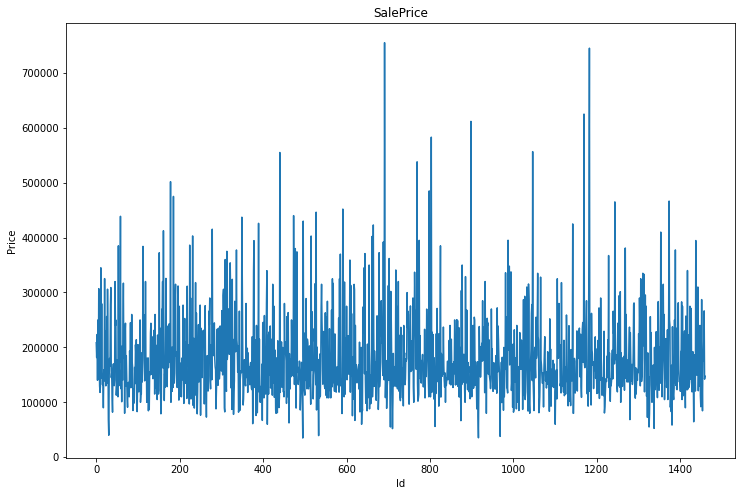

In [51]:
train.SalePrice.plot(figsize=(12,8))
plt.title('SalePrice')
plt.ylabel('Price')
plt.xlabel('Id');

### Outliers are the cause of such difference between median and mean statistic of the 'SalePrice' column

In [52]:
train.SalePrice.agg([np.mean,np.median])

mean      180921.19589
median    163000.00000
Name: SalePrice, dtype: float64

### Distribution graph,probplot and shapiro-wilk test show that target value(SalePrice) is normally distributed

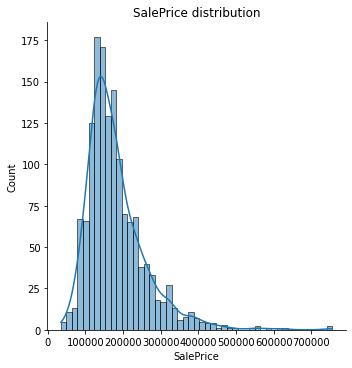

In [53]:
sns.displot(train.SalePrice,kde=True)
plt.title('SalePrice distribution');


shapiro-wilk test : 3.206247534576162e-33


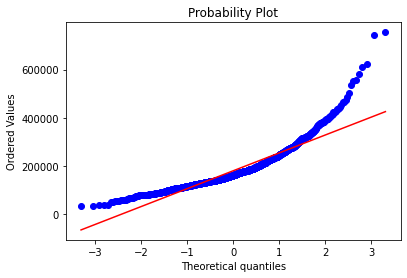

In [54]:
stats.probplot(train.SalePrice,plot=plt)[1]
print('shapiro-wilk test :',
      stats.shapiro(train.SalePrice)[1])

### Separating numeric and categoric values in dataset

In [55]:
numeric = np.where((train.dtypes=='int')|(train.dtypes=='float'))[0]
categoric = np.where(train.dtypes=='object')[0]
print('Numerical features : ',train.columns[numeric].values,'\nAmount: ',len(numeric))
print('Categorical features : ',train.columns[categoric].values,'\nAmount:',len(categoric))
print('Numeric-categoric ratio = {} that is close to 1 '.format(round(len(numeric)/len(categoric),2)))

Numerical features :  ['Id' 'MSSubClass' 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF'
 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt'
 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold' 'YrSold'
 'SalePrice'] 
Amount:  38
Categorical features :  ['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation'
 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' 'KitchenQual'
 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish' 'Gara

## Function for cleaning data
### Drops columns with 40 or more percentage of missing values
### Fillining 'nan' with median in numeric and most frequent in categoric column

In [56]:
def cleaning_na(data):
    columns_with_na = np.where(data.isna().sum()>0)[0]
    columns_to_drop = (data.iloc[:,columns_with_na].isna().sum()/data.shape[0]*100)>40
    columns_number = columns_with_na[np.where((data.iloc[:,columns_with_na].dtypes=='float')|(data.iloc[:,columns_with_na].dtypes=='int'))[0]]
    columns_cat =  columns_with_na[np.where(data.iloc[:,columns_with_na].dtypes=='object')[0]]
    data.iloc[:,columns_number] = data.iloc[:,columns_number].apply(lambda x:x.fillna(x.median()))
    for column in columns_cat:
        data.iloc[:,column].fillna(data.iloc[:,column].mode()[0],inplace=True)
    data.drop(data.columns[columns_with_na[columns_to_drop]],axis=1,inplace=True)
    data.drop('Id',axis=1,inplace=True)
cleaning_na(train)
cleaning_na(test)

## Pearson and Spearman linear correlation  test 
### Results <0.05 can be omitted in further calculation

In [57]:
numeric = np.where((train.dtypes=='int')|(train.dtypes=='float'))[0]
pear = {}
spear = {}
for col in numeric:
    col_name = train.columns[col]
    pear[col_name] = stats.pearsonr(train[col_name],train['SalePrice'])[0]
    spear[col_name] = stats.spearmanr(train[col_name],train['SalePrice'])[0]

In [58]:
print('Statistically insignificant(pearson corr)')
feat_to_drop_pear = {}
for feature in pear.items():
    if abs(feature[1])<0.05:
        feat_to_drop_pear[feature[0]]=feature[1]
print(pd.Series(feat_to_drop_pear))

Statistically insignificant(pearson corr)
BsmtFinSF2     -0.011378
LowQualFinSF   -0.025606
BsmtHalfBath   -0.016844
3SsnPorch       0.044584
MiscVal        -0.021190
MoSold          0.046432
YrSold         -0.028923
dtype: float64


In [59]:
print('Statistically insignificant(spearman corr)')
feat_to_drop_spear = {}
for feature in spear.items():
    if abs(feature[1])<0.05:
        feat_to_drop_spear[feature[0]]=feature[1]
print(pd.Series(feat_to_drop_spear))

Statistically insignificant(spearman corr)
MSSubClass      0.007192
BsmtFinSF2     -0.038806
BsmtHalfBath   -0.012189
YrSold         -0.029899
dtype: float64


As we can see these columns are indeed haven't any correlation with SalePrice

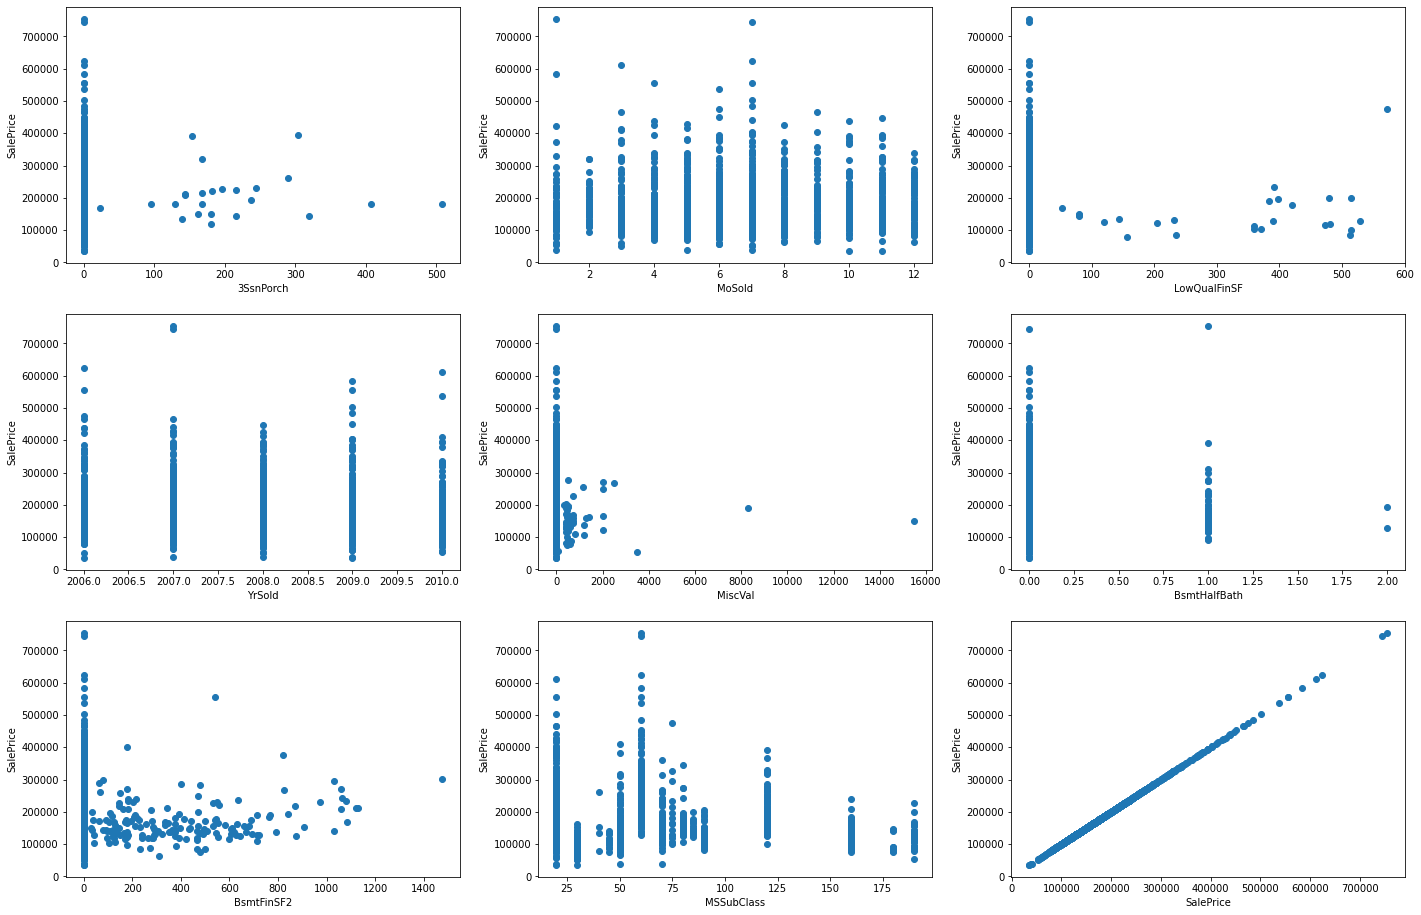

In [60]:
feat_to_draw = list(set(feat_to_drop_pear.keys()).union(set(feat_to_drop_spear.keys()))) 
feat_to_draw.append('SalePrice')
plt.figure(figsize=(24,16))
for i in range(len(feat_to_draw)):
    plt.subplot(3,3,i+1)
    plt.scatter(train[feat_to_draw[i]],train.SalePrice)
    plt.xlabel(str(feat_to_draw[i]))
    plt.ylabel('SalePrice')

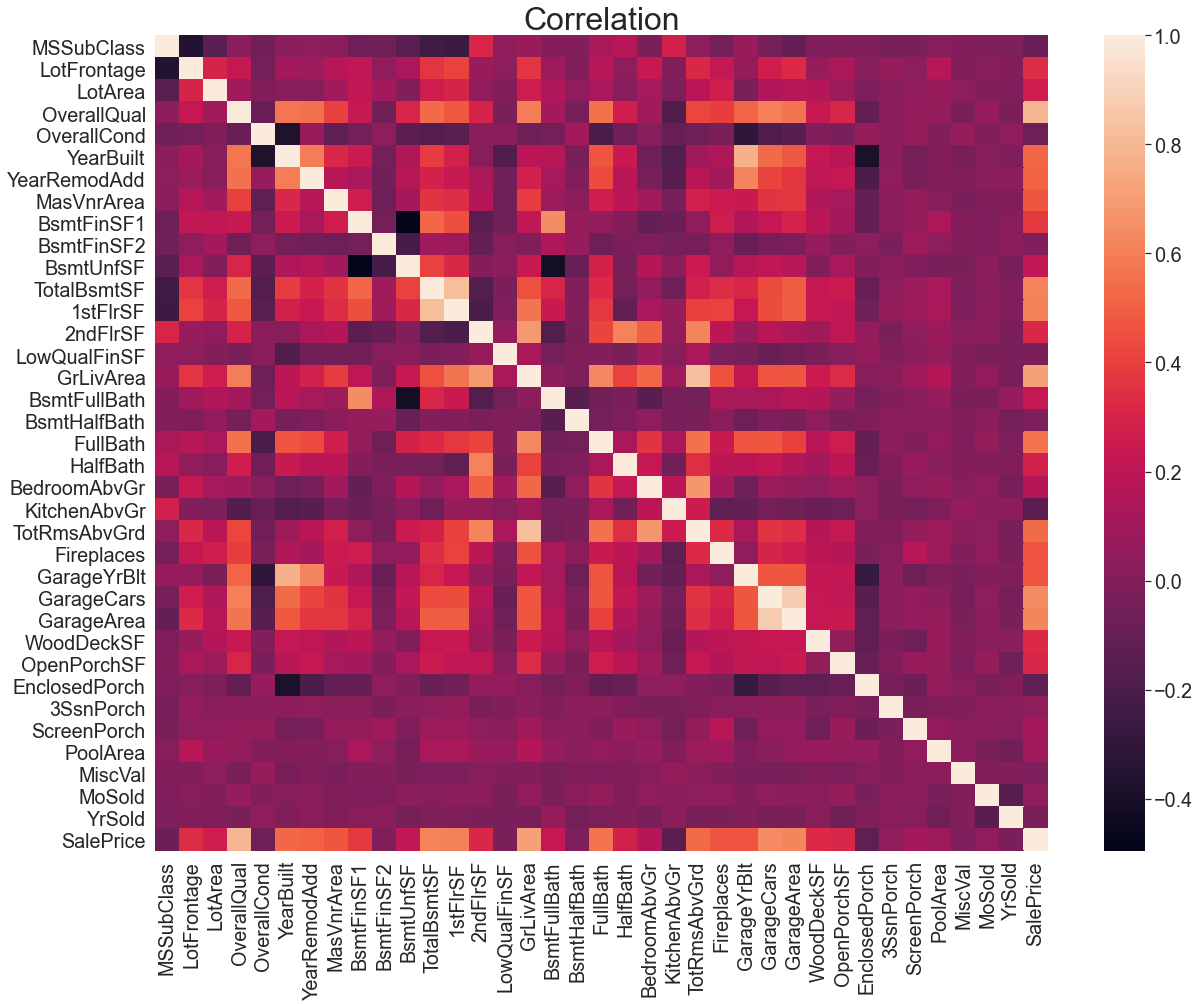

In [61]:
#Correlation map to see how features are correlated with SalePrice
corr = train.corr()
plt.figure(figsize=(20,15))
sns.set(font_scale=1.8)
sns.heatmap(corr)
plt.title('Correlation',fontsize=32);

Basic regression model with statistical useful information 

In [62]:
train.rename(columns={'1stFlrSF':'FirstFlrSF','2ndFlrSF':'SecondFlrSF','3SsnPorch':'ThirdSsnPorch'},inplace=True)
test.rename(columns={'1stFlrSF':'FirstFlrSF','2ndFlrSF':'SecondFlrSF','3SsnPorch':'ThirdSsnPorch'},inplace=True)
feats = list(train.columns[numeric].drop('SalePrice'))
features_string = " + ".join(feats)

In [63]:
regression_model = smf.ols('SalePrice ~ ' + features_string , data=train)
fitted = regression_model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     182.4
Date:                Wed, 23 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:20:19   Log-Likelihood:                -17319.
No. Observations:                1460   AIC:                         3.471e+04
Df Residuals:                    1425   BIC:                         3.489e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.628e+05   1.41e+06      0.327

In [64]:
# probably these features do not affect much on regression model 
feats = np.array(feats)
feats_pvalue = fitted.pvalues>0.65
feats[feats_pvalue[1:]]

array(['BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GarageArea',
       'OpenPorchSF', 'MiscVal', 'MoSold'], dtype='<U13')

In [66]:
#droping not necessary columns
feat_to_drop = list(set(feat_to_drop_pear).union(set(feat_to_drop_spear)).union(set(feats[feats_pvalue[1:]])))
feats = set(train.columns[numeric].drop('SalePrice')).intersection(set(feat_to_drop))
train.drop(feats, axis=1, inplace=True)
test.drop(feats, axis=1, inplace=True)

## Preproccesing:
### Normalization of numeric features
### OneHotEncoding of categoric features

In [249]:
# Separation target value
X = train.drop('SalePrice',axis=1)
y = train.SalePrice
categorical_cols = np.where(X.dtypes=='object')[0]
numerical_cols = np.where((X.dtypes=='float')|(X.dtypes=='int'))[0]

In [250]:
# classes for preprocessing
scaler = StandardScaler()
cat = OneHotEncoder(handle_unknown='ignore')

In [251]:
#normalization 
X.iloc[:,numerical_cols] = scaler.fit_transform(X.iloc[:,numerical_cols])
test.iloc[:,numerical_cols] = scaler.transform(test.iloc[:,numerical_cols])
#onehotencoding
X_cat = cat.fit_transform(X.iloc[:,categorical_cols])
test_cat = cat.transform(test.iloc[:,categorical_cols])

In [252]:
X_all = X.drop(X.columns[categorical_cols],axis=1,inplace=True)
test_all = test.drop(test.columns[categorical_cols],axis=1,inplace=True)
X_all = np.hstack((X,X_cat.toarray()))
test_all = np.hstack((test,test_cat.toarray()))

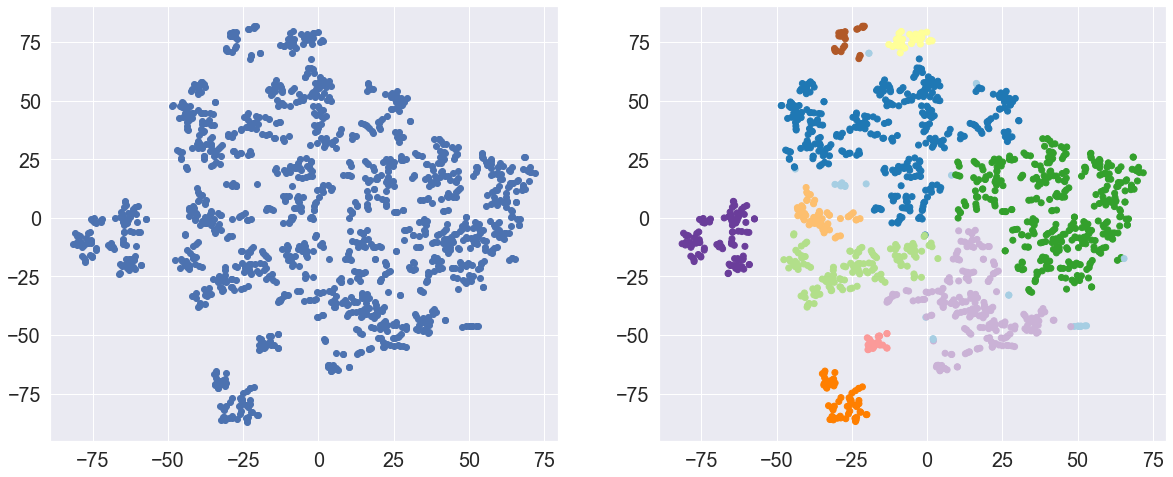

In [261]:
# 2d interpretaion of values
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
numeric = np.where((X.dtypes == 'int')|(X.dtypes == 'float'))[0]
tsne = TSNE(perplexity=10,random_state=5)
tsne_result = tsne.fit_transform(X.iloc[:,numeric])
plt.scatter(tsne_result[:,1],tsne_result[:,0])
# clustering
plt.subplot(1,2,2)
dbscan = DBSCAN(eps=7,min_samples=12).fit_predict(tsne_result)
plt.scatter(tsne_result[:,1],tsne_result[:,0],c=dbscan,cmap='Paired');
#Many clusters stand apart, which means that something unites them

## Extracting most valuable numeric features
### Feature selection with lasso algorithm

In [44]:
# Lasso feature selection
numeric=np.where((X.dtypes=='int')|(X.dtypes=='float'))[0]
lasso = Lasso(alpha=10000,random_state=5)
fitted = lasso.fit(X.iloc[:,numeric],y)
pd.DataFrame({'coef':fitted.coef_},index = train.columns[numeric]).sort_values(by='coef',ascending=False)[:10]

NameError: name 'X' is not defined

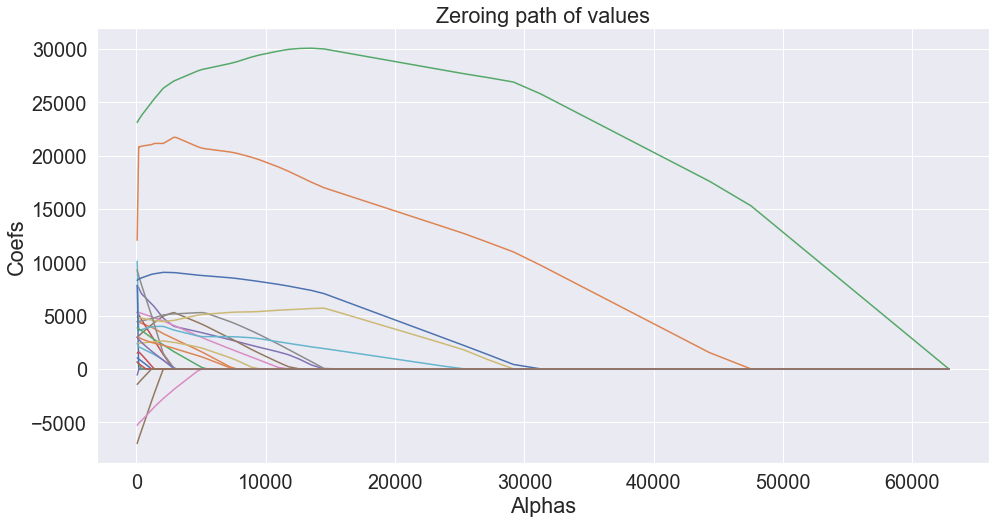

In [283]:
#path of total zeroing feats
alphas,coefs,_ = lasso_path(X.iloc[:,numeric],y)
plt.figure(figsize=(16,8))
plt.plot(alphas,coefs.T)
plt.xlabel('Alphas')
plt.ylabel('Coefs')
plt.title('Zeroing path of values');

In [286]:
# Lasso selecting works well after encoding categorical features
# Keeps most important feats
lasso = Lasso(alpha=200,random_state=5)
fitted = lasso.fit(X_all,y)
(pd.DataFrame({'coef':fitted.coef_}).sort_values(by='coef')!=0).sum()

coef    77
dtype: int64

In [288]:
# Lasso prediction before hyperparameter tuning 
# Score = 0.13573 on kaggle (better result than 60% of all compititors)
lasso = LassoCV(random_state=5).fit(X_all,y)
pred = lasso.predict(test_all)
pd.DataFrame({'Id':range(1461,1461+1459),'SalePrice':pred}).to_csv('first_answer.csv',index=False)